<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Weight_visualisations_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weight Visualisations
This notebook explores the possibilities for visualising the trained weights. The intent is to create some re-usable libraries that I can use on more advanced networks to help understand what they're doing. And in the process, learn some stuff.

The initial use case I've chosen is on an image classification task. Initial classification code based on tutorial: https://www.tensorflow.org/tutorials/keras/classification.

There are a few weight visualisations to explore:
* **Basic Info**: In order to understand the problems, I've done some basic plots of the weights themselves. This looks like a useful thing to turn into a generic "summarise" tool.
* **Feature strengths**: Some features are less important than others. There's a few logical steps of improvements possible here.
  * **1)** To measure this, run across the data set and look at the stddev of outputs from each of the features at a given layer. We can plot that to identify which features are more significant than others.
  * **2)** However, that alone isn't quite accurate, because it depends more on how those features are later used, and they may be disproportionately scalled by the subsequent layer. So, now use the next layer, takes its weights against feature, average them, use those averaged weights to scale the stddevs, and plot again. Now we have quite a realistic measure of the relative importance of different features.
  * **3)** Note that this too is just a "shallow" measure. The most accurate measure would be to look at how each individual feature affects the final output - calculating $\frac{do}{df}$ (delta in output w.r.t. the feature). Interestingly, that's just the gradient that's calculated during training. So, to calculate it we'd just want to grab the average gradient across the training set, once in a training state.
* **Curve**: Examine the interpretation of the weights+biases+relu activation in a single layer against a single input to construct a single non-linear curve.
* **Areas of interest (images only)**: by examining the magnitude of weights against different parts of the input image, we should see differences in the "areas of interest". There are two versions of this that both look at the differences in magnitude across the image:
  * **a)** larger vs smaller average weight magnitude for a given pixel
  * **b)** larger vs smaller stddev of weights for a given pixel
  * Note that the same actually applies to non-images, but it's easier to understand in terms of images, particularly because they have such a large input feature size.
* **Reverse Image Construction (images only)**: illustrate what different nodes look for by constructing input images that maximise the output of a given node.

Further thoughts...

**Curve:** There are further things to think about. For example, the current approach is perhaps naive and resource intensive, whereas there may be a more direct way of extracting what I want directly from the weight matrix using a little bit of maths.

In [158]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"train_images shape: {train_images.shape}")
print(f"train_labels shape: {train_labels.shape}")

4422102/4422102 [==============================] - 0s 0us/step
train_images shape: (60000, 28, 28)
train_labels shape: (60000,)


In [3]:
# pre-process into the correct data range
train_images = train_images / 255.0
test_images = test_images / 255.0

Show an example image:

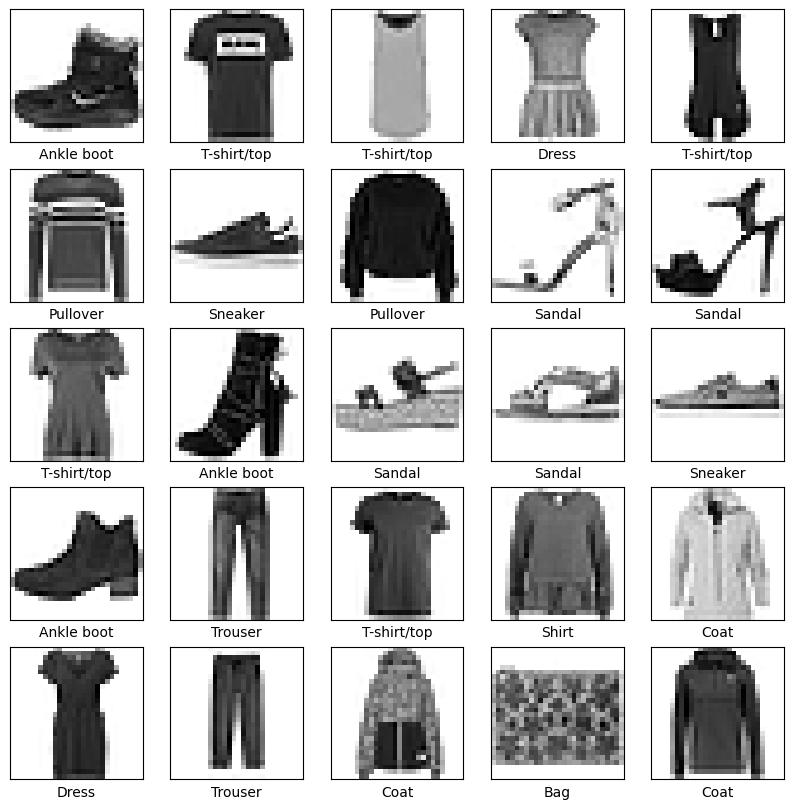

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [75]:
# Let's understand the range of data values.
min_value = np.min(train_images)
max_value = np.max(train_images)
default_value = np.mean(train_images)
default_values = np.mean(train_images, axis=0)
print(f"min value     : {min_value}")
print(f"max value     : {max_value}")
print(f"mean value    : {np.mean(train_images)}")
print(f"stddev        : {np.std(train_images)}")
print(f"default value : {default_value}")
print(f"default values: shape {default_values.shape}")

min value     : 0.0
max value     : 1.0
mean value    : 0.2860405969887955
stddev        : 0.35302424451492237
default value : 0.2860405969887955
default values: shape (28, 28)


## Model

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4986 - accuracy: 0.8243
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3755 - accuracy: 0.8648
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3345 - accuracy: 0.8775
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3106 - accuracy: 0.8858
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2941 - accuracy: 0.8911
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2808 - accuracy: 0.8962
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2655 - accuracy: 0.9012
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2548 - accuracy: 0.9047
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2481 - accuracy: 0.9071
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.237

In [7]:
# Let's examine the shape of the weights
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.get_layer("dense").variables

[<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
 array([[ 5.03989309e-02,  1.69979125e-01, -2.12891333e-04, ...,
         -1.25070930e-01, -6.89960271e-02, -1.44512087e-01],
        [-4.09412891e-01, -3.70332338e-02, -2.10480481e-01, ...,
          7.13262558e-02, -8.74514878e-02, -2.26442218e-01],
        [-5.16334593e-01, -1.69449691e-02, -6.42950535e-02, ...,
         -3.24591517e-01, -8.41576681e-02, -9.08428058e-02],
        ...,
        [-1.10738516e-01, -9.26074162e-02,  5.14368601e-02, ...,
          1.36104792e-01,  1.13827340e-01,  5.22612706e-02],
        [ 1.29705267e-02, -3.95737179e-02,  3.24994594e-01, ...,
          2.69081503e-01, -4.22061682e-02,  1.67748258e-01],
        [ 7.09225908e-02,  3.65457535e-02,  1.71159282e-01, ...,
         -2.20427111e-01, -1.05807908e-01,  2.78515130e-01]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 2.48072043e-01,  4.29623902e-01,  2.48756364e-01, -1.01194181e-01,
   

In [9]:
weights = model.get_layer("dense").variables[0].numpy()
bias    = model.get_layer("dense").variables[1].numpy()
print(f"weights shape: {weights.shape}")
print(f"bias    shape: {bias.shape}")

weights shape: (784, 128)
bias    shape: (128,)


## Let's first understand the raw weights

(array([ 8.,  4., 13., 22., 27., 19., 18., 10.,  4.,  3.]),
 array([-0.44371712, -0.30932045, -0.17492378, -0.04052711,  0.09386957,
         0.22826624,  0.36266291,  0.49705958,  0.63145626,  0.76585293,
         0.9002496 ]),
 <BarContainer object of 10 artists>)

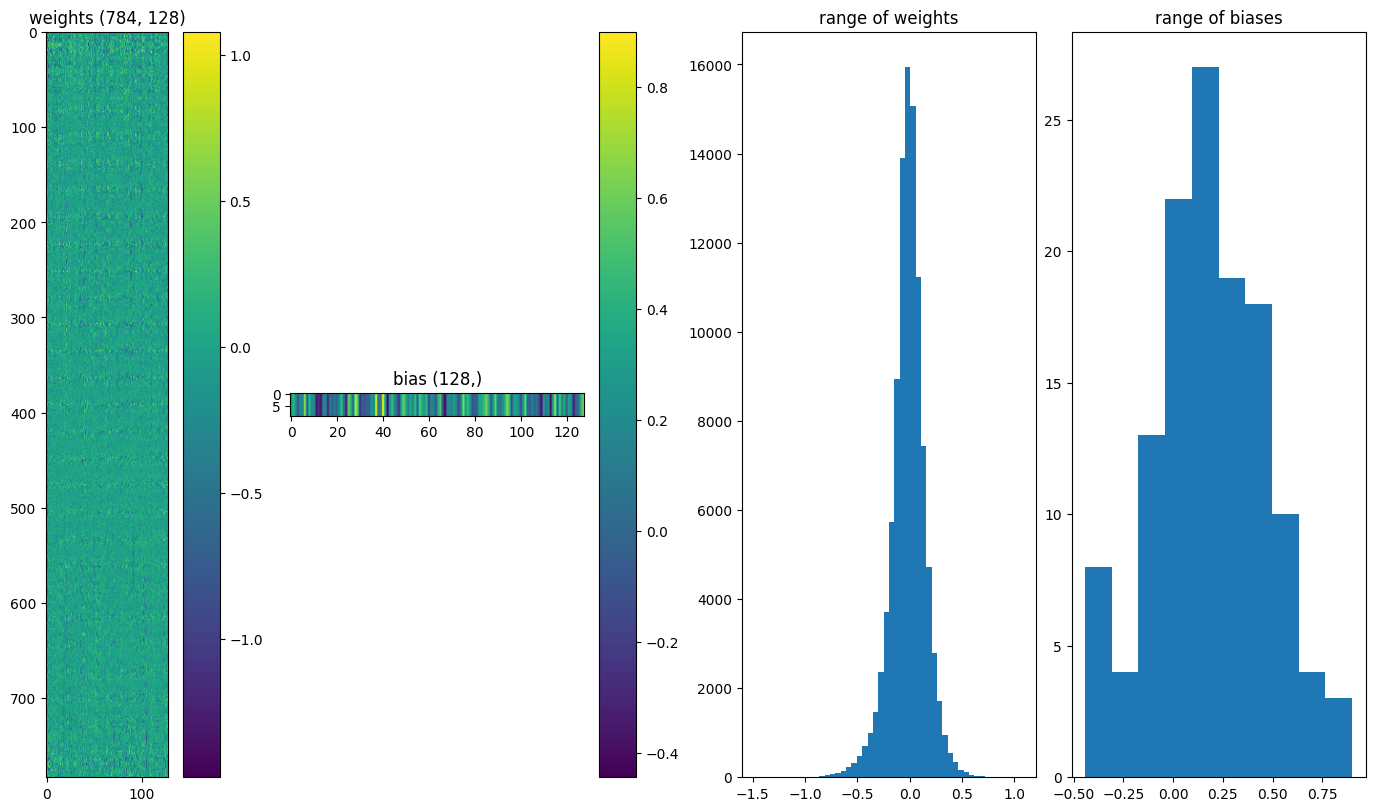

In [147]:
plt.figure(figsize=(15,8), layout='constrained')
plt.subplot(1,4,1)
plt.title(f"weights {weights.shape}")
plt.imshow(weights)
plt.colorbar()
plt.subplot(1,4,2)
plt.title(f"bias {bias.shape}")
plt.imshow(np.tile(bias,(10,1)))
plt.colorbar()
plt.subplot(1,4,3)
plt.title("range of weights")
plt.hist(weights.reshape(-1,1),bins=50)
plt.subplot(1,4,4)
plt.title("range of biases")
plt.hist(bias,bins=10)

Let's try to understand how those weights relate back to the input images.

In the first layer there are 128 features. For each feature independently, some of the input pixels will be more interesting than others. This should be indicated by having greater weights. Given that there's only 128 features, let's just plot those weights as input images against each feature:

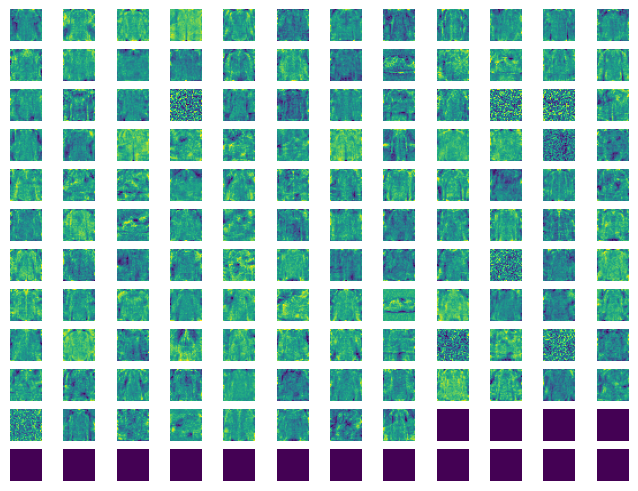

In [104]:
# note that in the figure, the weight images are all automatically scaled to their individual min/max ranges
fig = plt.figure(layout='constrained')
axs = fig.subplots(12,12)
idx = 0
for row in range(12):
  for col in range(12):
    if idx < 128:
      img = weights[:,idx].reshape(28,28)
    else:
      img = np.zeros((28,28))
    axs[row,col].imshow(img)
    axs[row,col].set_axis_off()
    idx += 1

These are effectively heatmaps of weights.
Notice that each image is automatically and independently scaled by matplotlib. That's good because, without further information from other parts of the model, weights across different features are not on comparable scales.

Now, if we average across these scaled images, we'll get one image that represents the relative interest across each input image pixel:

feature_min shape: (128,)
feature_max shape: (128,)
interest_image shape: (28, 28)


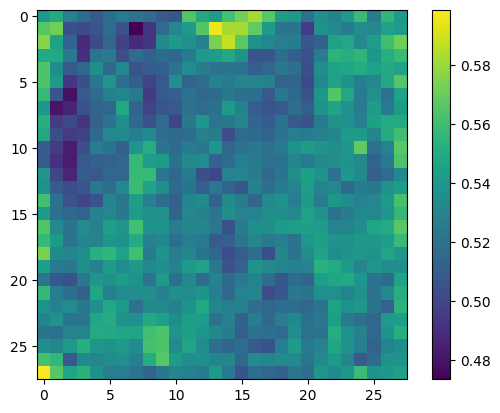

In [148]:
feature_min = np.min(weights,axis=0)
feature_max = np.max(weights,axis=0)
print(f"feature_min shape: {feature_min.shape}")
print(f"feature_max shape: {feature_max.shape}")
normalised_weights = (weights - feature_min) / (feature_max - feature_min)
interest_image = np.mean(normalised_weights,axis=1).reshape(28,28)
print(f"interest_image shape: {interest_image.shape}")

plt.figure()
plt.imshow(interest_image)
plt.colorbar()

To be even more precise, we need to consider that some features at this first layer are more significant than others. We can only find that out by looking at the next layer.
So let's get that information and plot the list of features again, but this time scaled by their relative importance for the next layer:

output layer weights shape: (128, 10)
feature strengths shape: (128,)


(array([30., 45., 29., 16.,  3.,  1.,  2.,  0.,  1.,  1.]),
 array([0.07730055, 0.15815504, 0.23900953, 0.31986403, 0.40071851,
        0.48157302, 0.56242752, 0.643282  , 0.72413647, 0.80499101,
        0.88584548]),
 <BarContainer object of 10 artists>)

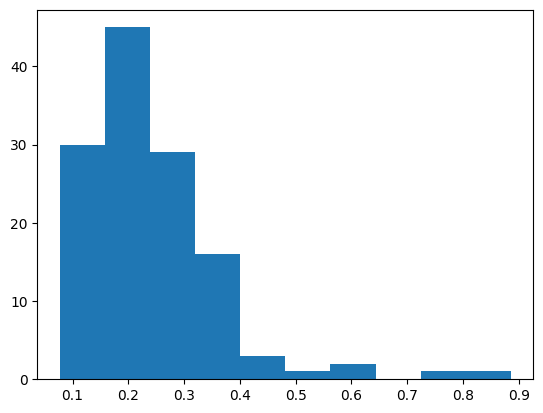

In [153]:
# here I'll use "feature strengths" to refer to the relative weighting applied to each of the 128 features in the first layer
# (using "strengths" to avoid overloading "weights" term already in use)
outlayer_weights = model.get_layer("dense_1").variables[0].numpy()
print(f"output layer weights shape: {outlayer_weights.shape}")
feature_strengths = np.mean(np.abs(outlayer_weights),axis=1)
print(f"feature strengths shape: {feature_strengths.shape}")
plt.figure()
plt.hist(feature_strengths)

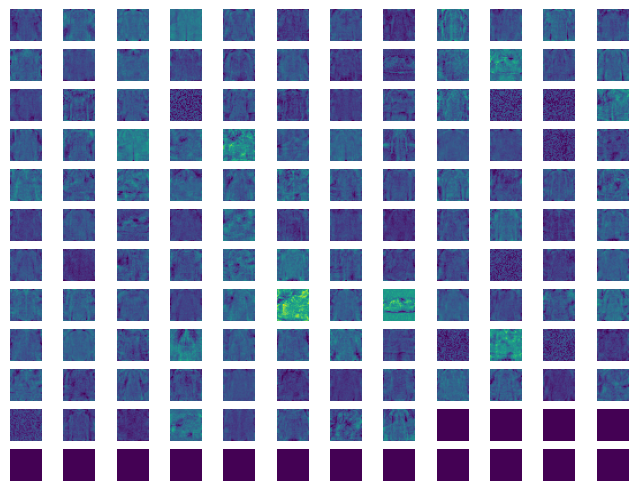

In [160]:
# Re-using 'normalised_weights' computed above and forcing matplotlib to use the same scale
# We'll apply feature_strengths, but modified by sqrt() because a lot of the values are close to zero and it's harder to see the features
fig = plt.figure(layout='constrained')
axs = fig.subplots(12,12)
idx = 0
for row in range(12):
  for col in range(12):
    if idx < 128:
      img = normalised_weights[:,idx].reshape(28,28) * math.sqrt(feature_strengths[idx])
    else:
      img = np.zeros((28,28))
    axs[row,col].imshow(img, vmin=0.0, vmax=1.0)
    axs[row,col].set_axis_off()
    idx += 1

Indices of pixels with largest weight/bias ratio: [511  43  28 681 728 509 757  69  70  16 392  56  42  29  41 756]


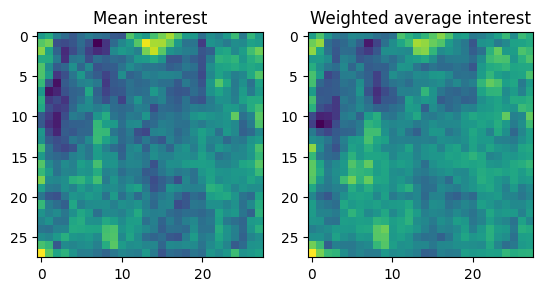

In [216]:
# Generating the single image
interest_image1 = np.mean(normalised_weights,axis=1).reshape(28,28)
interest_image2 = np.mean(normalised_weights * feature_strengths,axis=1).reshape(28,28)

plt.figure()
plt.subplot(1,2,1)
plt.title("Mean interest")
plt.imshow(interest_image1)
plt.subplot(1,2,2)
plt.title("Weighted average interest")
plt.imshow(interest_image2)

# Pixel indices with greatest effect (against flattened shape)
greatest_effect_indices = interest_image2.reshape(-1).argsort()[-16:]
print(f"Indices of pixels with largest weight/bias ratio: {greatest_effect_indices}")

## Simple weight plotting

In [10]:
## Simple weight plotting
x0 = np.linspace(min_value, max_value, 100)
sim_images = np.full((len(x0),28,28), default_value)
sim_images[:,15,15] = x0

In [22]:
sim_images.shape

(100, 28, 28)

In [11]:
sim_images[:,15,15]

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

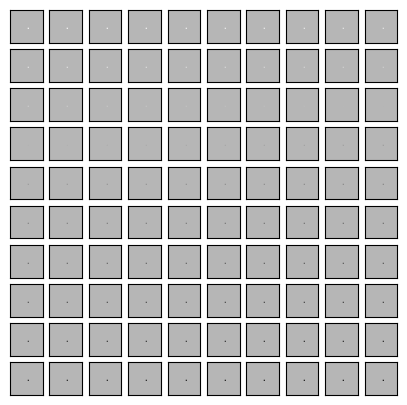

In [12]:
plt.figure(figsize=(5,5))
for i in range(len(x0)):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sim_images[i], cmap=plt.cm.binary, vmin=0, vmax=1.0)
plt.show()

In [230]:
inputs = sim_images.reshape(-1,28*28)
outputs = np.matmul(inputs, weights) + bias
outputs = np.maximum(0, outputs)
value = np.sum(outputs, axis=1)
print(f"outputs.shape: {outputs.shape}")
print(f"value.shape:   {value.shape}")

outputs.shape: (100, 128)
value.shape:   (100,)


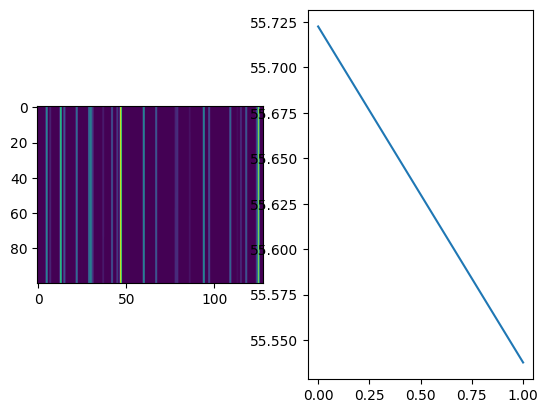

In [231]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(outputs)
plt.subplot(1,2,2)
plt.plot(x0, value)

**Commentary:**
* Weighted average for true curve:
   * To get the most accurate results I'd now pass these output activations into a node in the next layer so that it's different weights against these different outputs can be applied. Only then do you see the curve that the model is actually consuming internally. However, that creates a multivariate effect which makes it harder to pick a small number of visualisations. Also, because this plot is show boring, adding different weights isn't going to change anything much.
* $(x0,x1)$
  * I had considered plotting 2D heatmaps to optimise by showing 2 variables together at the same time. This should also provide interesting results. However, given a 28x28 image, there's too many different possible combinations, so it's better in this case to plot each pixel-variable independently. That way I've only got 28x28 plots to show.
* Boring
  * This plot is too boring to continue with next steps on its own. So I'll focus on generating a grid of such plots so I can find something interesting to look at.

## Multi-plot

In [223]:
def get_output_curve(layer, coord, values, default_values):
  """
  Computes the output activations and summed curve for the range of values applied to the given coordinate.
  Generates synthetic layer inputs with default_values for all cells except for the given 'coord', which is
  given the supplied range of values.
  Args:
    layer                  : assumed to be a Dense layer
    coord  (int)           : coordinate to apply values, according to input shape of layer
    values (ndarray (v,))  : a range of input values to try against the coordinate
    default_values (scalar or ndarray (n,)) :
                             default value or values for all other input cells.
                             Either a scalar, or an array of same size as input vector.
  Returns
    curve       (ndarray (v,))
    activations (ndarray (v,j)) : activations from each node in the layer
  """
  if not isinstance(layer, tf.keras.layers.Dense):
    raise Exception(f"Not a supported layer type: {type(layer)}")
  if not np.isscalar(coord):
    raise Exception(f"Coord must be an integer scalar")

  weights = layer.variables[0].numpy()
  bias    = layer.variables[1].numpy()
  in_width  = weights.shape[0]
  out_width = weights.shape[1]
  #print(f"weights shape: {weights.shape}")
  #print(f"bias    shape: {bias.shape}")

  if coord < 0 or coord >= in_width:
    raise Exception(f"Coord must be in range [0,{in_width}): {coord}")
  if not np.isscalar(default_values) and default_values.shape != (in_width,):
    raise Exception(f"default_values must be either scalar or have shape ({in_width},): {default_values.shape}")

  input = np.full((len(values), in_width), default_values)
  input[:,coord] = values

  outputs = np.matmul(input, weights) + bias
  outputs = np.maximum(0, outputs)              # TODO apply activation function from layer config
  curve = np.sum(outputs, axis=1)
  #print(f"activation.shape: {outputs.shape}")
  #print(f"curve.shape:      {value.shape}")

  return (curve, outputs, input)

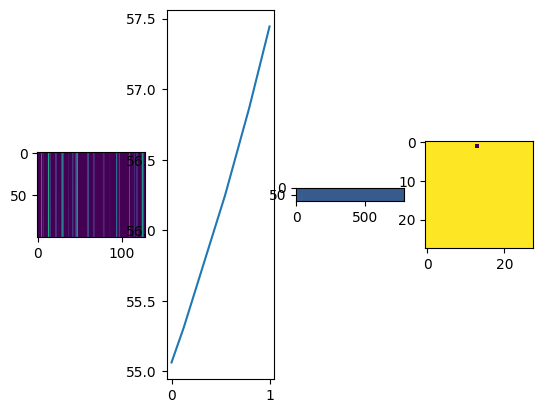

In [200]:
# largest weight indices: 511  43  28 681 728 509 757  69  70  16 392  56  42  29  41 756
coord = 41
v = np.linspace(min_value, max_value, 100)
(c, a, inp) = get_output_curve(model.get_layer("dense"), coord, v, default_value)

plt.figure()
plt.subplot(1,4,1)
plt.imshow(a)
plt.subplot(1,4,2)
plt.plot(v, c)
plt.subplot(1,4,3)
plt.imshow(inp)
plt.subplot(1,4,4)
plt.imshow(inp[0].reshape(28,28))

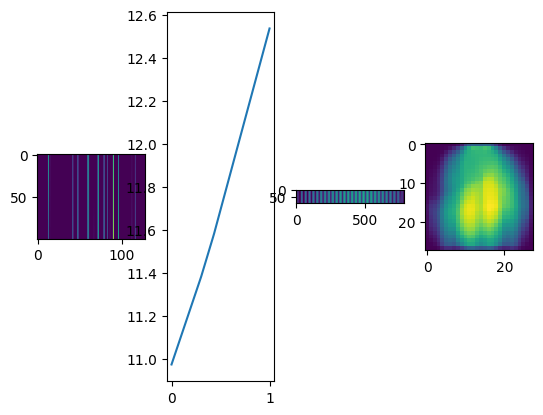

In [197]:
# same as above but setting to per-pixel means
v = np.linspace(min_value, max_value, 100)
(c, a, inp) = get_output_curve(model.get_layer("dense"), coord, v, default_values.reshape(-1))

plt.figure()
plt.subplot(1,4,1)
plt.imshow(a)
plt.subplot(1,4,2)
plt.plot(v, c)
plt.subplot(1,4,3)
plt.imshow(inp)
plt.subplot(1,4,4)
plt.imshow(inp[0].reshape(28,28))

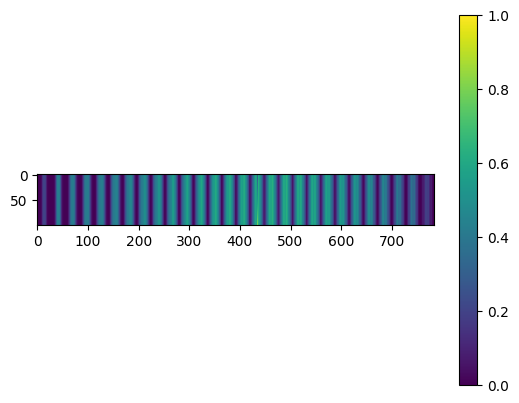

In [83]:
plt.figure()
plt.imshow(inp)
plt.colorbar()

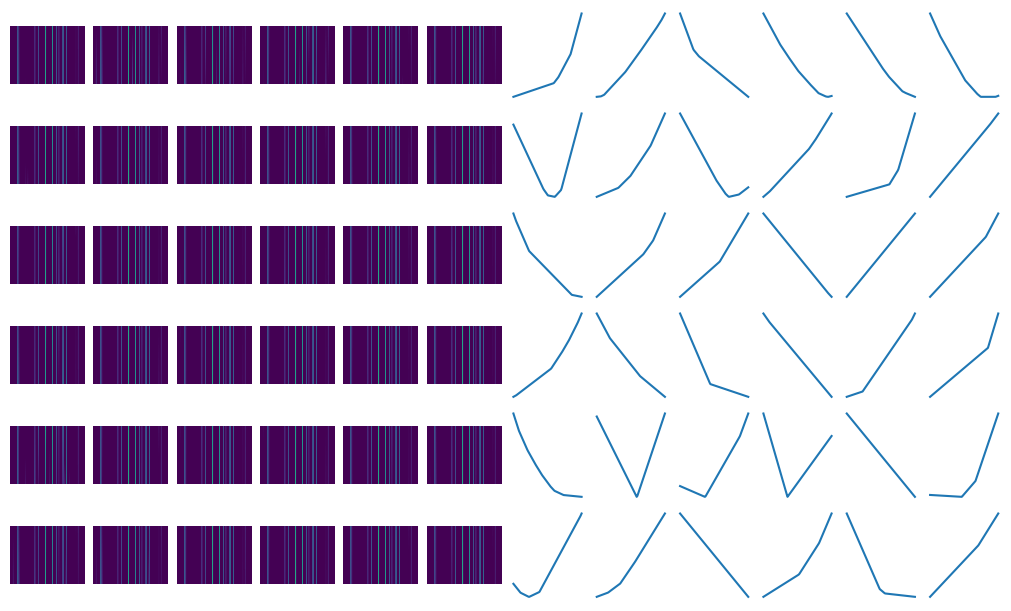

In [215]:
# Iterate over a number of coords chosen on a grid pattern and plot all the results
# Tip: experiment using default_value or default_values.
layer = model.get_layer("dense")
values = np.linspace(min_value, max_value, 100)
results = list()
for x in range(0,28,5):
  for y in range(0,28,5):
    #print(f"({x},{y}) -> {y*28+x}")
    #(c, a, _) = get_output_curve(layer, y*28+x, values, default_value)
    (c, a, _) = get_output_curve(layer, y*28+x, values, default_values.reshape(-1))
    results.append({
        "x": x,
        "y": y,
        "c": c,
        "a": a
    })

fig = plt.figure(figsize=(10,6), layout='constrained')
axs = fig.subplots(6,12)
for row in range(6):
  for col in range(6):
    idx = row*6+col
    res = results[idx]
    axs[row,col].imshow(res["a"])
    axs[row,col].set_axis_off()
    axs[row,col+6].plot(values, res["c"])
    axs[row,col+6].set_axis_off()

Plotting: 4 x 4


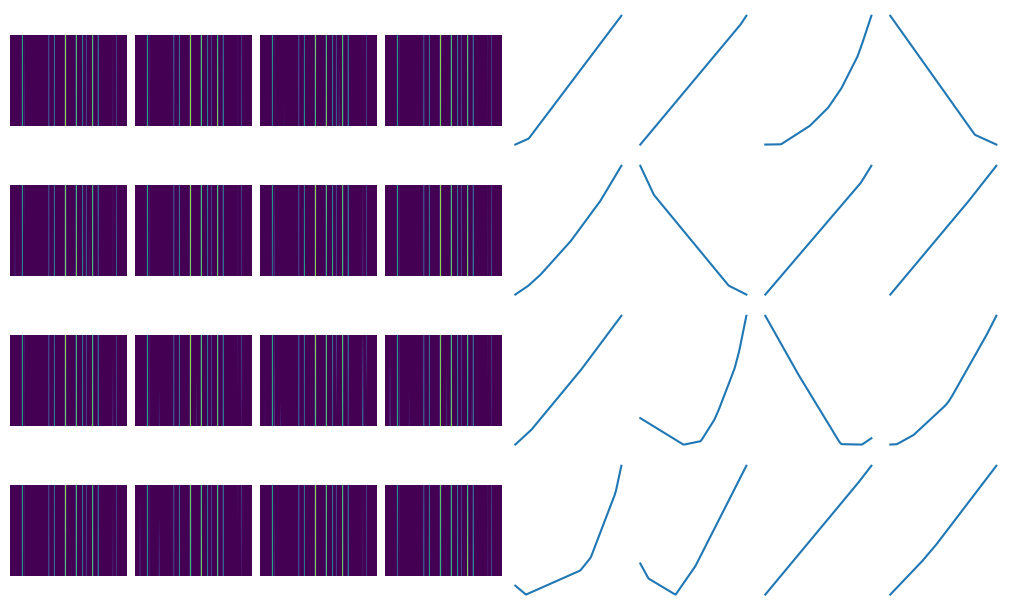

In [229]:
# Iterate over a number of coords and plot all the results
# - this time using the most effective pixels:
# Tip: experiment using default_value or default_values.
layer = model.get_layer("dense")
values = np.linspace(min_value, max_value, 100)
results = list()
for idx in greatest_effect_indices:
  #(c, a, _) = get_output_curve(layer, idx, values, default_value)
  (c, a, _) = get_output_curve(layer, idx, values, default_values.reshape(-1))
  results.append({
      "x": x,
      "y": y,
      "c": c,
      "a": a
  })

fig = plt.figure(figsize=(10,6), layout='constrained')
cols = math.floor(math.sqrt(len(results)))
rows = math.ceil(len(results)/cols)
print(f"Plotting: {rows} x {cols}")
axs = fig.subplots(rows,cols*2)
idx = 0
for row in range(rows):
  for col in range(cols):
    if idx < len(results):
      res = results[idx]
    else:
      res = {
          "a": np.zeros(2,2),
          "c": np.zeros(len(values),)
      }
    res = results[idx]
    axs[row,col].imshow(res["a"])
    axs[row,col].set_axis_off()
    axs[row,col+cols].plot(values, res["c"])
    axs[row,col+cols].set_axis_off()
    idx += 1

**Learnings so far:**
* **Success**: I'm finally starting to get some curves. In fact, I'm seeing interesting curves against randomly chosen image pixels and when targeting the pixels with the strongeth effects, and I'm not seeing much difference in the forms of the results. That's promising for the possibility of creating an automated package for this visualisation.
* **Simple**: The curves are all very simple. It's no wonder that KNNs use simple splines to represent weights and get just as good results with significantly less weights. We're really not getting the full benefit of our weights.
* **Curse of averages**: One of the problems I've realised is that a single pixel is just one in 748 weights. So it's effect gets averaged out to nothing. This is probably the biggest reason why I'm getting such simple curves across 128 nodes. They look like they've only got about 3 nodes constructing them. The reality is that those 128 nodes represent a very complex combination of something like 748! (factorial) different curves.

Next steps:
* At this point, it's perhaps worth re-scaling the curves according to `feature_strengths`. It's clear from the apparent uniformity of the activation plots that there's large unchanging values that are taking the largest effect. It's possible that the relative feature_strengths will reduce that skew.
* It would also be interesting to just uniformly scale all pixels instead of changing just one. The problem is that any curves produced aren't really representative of anything real - they're represntative of what happens if we lock all pixels together - which doesn't happen in reality. But we might get more interesting curves.